In [14]:
import numpy as np
import matplotlib.pyplot as plt
import vector
import pandas as pd
import lhapdf
import itertools
from collections import defaultdict
import functools

## General code for calculating polarization vector

In [15]:
# Tau mass
mtau = 1.77682 # GeV

def polarization_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
  
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    # DUNE paper eq 10, 11, 12
    F = (
        (2*W1 + mtau**2/M**2 * W4) * (Etau - ptau * costheta) + W2 * (Etau + ptau * costheta) - W5 * mtau**2 / M
        # Only difference with tau polarization paper is that it is -W3 instead of +W3
        - W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
    )

    return (
        # P_T. Only difference with tau polarization paper is that it is -W3 instead of +W3
        -mtau * np.sin(theta) * (2*W1 - W2 - mtau**2 / M**2 * W4 + W5 * Etau / M - W3 * Enu / M) / F,
        # P_L
        -(
            (2*W1 - mtau**2/M**2 * W4) * (ptau - Etau * costheta) + W2 * (ptau + Etau * costheta) - W5 * mtau**2 / M * costheta
            # Only difference with tau polarization paper is that it is -W3 instead of +W3
            - W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
        ) / F
    )

    # R = (
    #     (Etau - ptau * costheta) / M * (W1 + mtau**2 / (2*M**2)*W4)
    #     + (Etau + ptau * costheta) / (2*M) * W2
    #     + ((Enu + Etau) / M * (Etau - ptau * costheta) / (2*M) - mtau**2 / (2*M**2)) * W3
    #     - mtau**2 / (2*M**2) * W5
    # )

    # return (
    #     # P_P component, in the tau-nu plane
    #     mtau * np.sin(theta) / (2*M*R) * (
    #         -(2*W1 - W2 - mtau**2/M**2 * W4 + Etau/M * W5) - Enu / M * W3 # X in lepton polarization paper, eq 7a
    #     ),
    #     # P_L component
    #     -1 + mtau**2/(M**2 * R) * (
    #         (2*M/(Etau + ptau) * W1 + (Etau - ptau) / (Etau + ptau) * W3) * np.cos(theta/2)**2
    #         + (M/(Etau + ptau) * W2 + (Etau + ptau) / M * W4 - W5) * np.sin(theta/2)**2
    #     ),
    # )


def spin_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        - mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )

def leptonic_weak_current(sign, mu, Enu, Etau, theta, ptau):
    if sign > 0:
        return np.sqrt(2*Enu*(Etau - ptau)) * [np.sin(theta/2), -np.cos(theta/2), 1j*np.cos(theta/2), np.sin(theta/2)][mu]
    return np.sqrt(2*Enu*(Etau + ptau)) * [np.cos(theta/2), np.sin(theta/2), -1j*np.sin(theta/2), np.cos(theta/2)][mu]

def leptonic_tensor(sign1, sign2, mu, nu, Enu, Etau, theta, ptau):
    return leptonic_weak_current(sign1, mu, Enu, Etau, theta, ptau) * np.conj(leptonic_weak_current(sign2, nu, Enu, Etau, theta, ptau))

#An antisymmetric tensor where epsilon(0, 1, 2, 3) = 1
@functools.cache
def epsilon_tensor(i, j, k, l):
    indices = [i, j, k, l]
    if len(set(indices)) != 4:
        return 0  # If any indices are repeated, the result is zero
    permutation = [0, 1, 2, 3]
    sign = 1
    for p in range(4):
        for q in range(p+1, 4):
            if indices[permutation[p]] > indices[permutation[q]]:
                sign *= -1
    return sign

metric_tensor = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, -1]
])

index2name = ["t", "x", "y", "z"]

def hadronic_tensor(mu, nu, W1, W2, W3, W4, W5, p, q, M):
    # assert q[index2name[mu]].shape == W1.shape

    return (
        -metric_tensor[mu, nu] * W1
        + p[index2name[mu]] * p[index2name[nu]] / M**2 * W2 
        - 1j*np.sum([
            epsilon_tensor(mu, nu, alpha, beta) * p[index2name[alpha]] * q[index2name[beta]] / (2*M**2) * W3
            for alpha, beta in itertools.product(range(4), repeat=2)
        ], axis=0)
        + q[index2name[mu]] * q[index2name[nu]] / M**2 * W4
        + (p[index2name[mu]] * q[index2name[nu]] + q[index2name[mu]] * p[index2name[nu]]) / (2*M**2) * W5
    )

def R(sign1: int, sign2: int, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M):
    return np.sum([
        leptonic_tensor(sign1, sign2, mu, nu, Enu, Etau, theta, ptau) * hadronic_tensor(mu, nu, W1, W2, W3, W4, W5, p, q, M)
        for mu, nu in itertools.product(range(4), repeat=2)
    ], axis=0)

def spin_vector2(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")

    Rpp = R(1, 1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    Rmm = R(-1, -1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    Rpm = R(1, -1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    Rmp = R(-1, 1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    
    assert np.allclose(Rmp.imag, -Rpm.imag), (Rmp, Rpm)
    # assert np.allclose(Rmp.imag, 0) This should be true in reality
    assert np.allclose(Rpm.real, Rmp.real)
    assert np.allclose(Rmm.imag, 0)
    assert np.allclose(Rpp.imag, 0)
    
    return (
        # sx component, in the tau-nu plane
        np.real((Rpm + Rmp) / (Rpp + Rmm) / 2),
        # sz component
        np.real((Rpp - Rmm) / (Rpp + Rmm) / 2)
    )

In [16]:
def boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=False, rotate_tau=True):
    """Change reference frame to one where the nucleon is at rest, the neutrino has a pure momentum in the +z direction, and the tau only has a momentum in the x and z directions.
    
    These are the three assumptions that exist for the formula to work. 
    The third assumption is most likely taken care for in the formulas automatically, since all formulas either use p*q, q**2 or some other parameter where the """
    # Replace the nucleon 4-momentum vectors that are incorrect
    # zero_nucleons = nucleon4m.E == 0
    assert not np.any(nucleon4m.E == 0)
    # nucleon_arr = np.array([nucleon4m.E, nucleon4m.px, nucleon4m.py, nucleon4m.pz])
    # nucleon_arr[0, zero_nucleons] = 0.98318
    # nucleon4m = vector.array({"E": nucleon_arr[0, :], "px": nucleon_arr[1, :], "py": nucleon_arr[2, :], "pz": nucleon_arr[3, :]})

    # Boost all vectors such that the nucleon is at rest
    tau4m_boosted = tau4m.boostCM_of(nucleon4m)
    nucleon4m_boosted = nucleon4m.boostCM_of(nucleon4m)
    nutau4m_boosted = nutau4m.boostCM_of(nucleon4m)

    # get the angles to rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
    phi = nutau4m_boosted.phi
    theta = nutau4m_boosted.theta

    # Rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
    nutau4m_rotated = nutau4m_boosted.rotateZ(-phi).rotateY(-theta)
    # Rotate all other momentum vectors, thereby preserving the 4-momentum conservation
    tau4m_rotated = tau4m_boosted.rotateZ(-phi).rotateY(-theta)
    nucleon4m_rotated = nucleon4m_boosted.rotateZ(-phi).rotateY(-theta)
    
    if not rotate_tau:
        return nutau4m_rotated, nucleon4m_rotated, tau4m_rotated
    
    tau_phi = tau4m_rotated.phi
    # Rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
    nutau4m_rotated2 = nutau4m_rotated.rotateZ(-tau_phi)
    # Rotate all other momentum vectors, thereby preserving the 4-momentum conservation
    tau4m_rotated2 = tau4m_rotated.rotateZ(-tau_phi)
    nucleon4m_rotated2 = nucleon4m_rotated.rotateZ(-tau_phi)

    if test:
        assert np.allclose(nucleon4m_boosted.px, 0), nucleon4m_boosted.px[~np.isclose(nucleon4m_boosted.px, 0)]
        assert np.allclose(nucleon4m_boosted.py, 0), nucleon4m_boosted.py[~np.isclose(nucleon4m_boosted.py, 0)]
        assert np.allclose(nucleon4m_boosted.pz, 0), nucleon4m_boosted.py[~np.isclose(nucleon4m_boosted.py, 0)]

        assert np.allclose(nutau4m_rotated.px, 0), nutau4m_rotated.px[~np.isclose(nutau4m_rotated.px, 0)]
        assert np.allclose(nutau4m_rotated.py, 0), nutau4m_rotated.py[~np.isclose(nutau4m_rotated.py, 0)]
        assert np.allclose(nutau4m_rotated.E, nutau4m_rotated.pz), nutau4m_rotated[~np.isclose(nutau4m_rotated.pz, nutau4m_rotated.E)]

        assert np.allclose(nucleon4m_rotated.px, 0)
        assert np.allclose(nucleon4m_rotated.py, 0)
        assert np.allclose(nucleon4m_rotated.pz, 0)

        assert np.allclose(tau4m_rotated2.py, 0), (tau4m_rotated2.py, tau4m_rotated.py)
        assert np.all(nutau4m_rotated2.isclose(nutau4m_rotated))
        assert np.all(nucleon4m_rotated2.isclose(nucleon4m_rotated))
        
        # Q^2
        assert np.allclose(-(nutau4m_rotated - tau4m_rotated)**2, -(nutau4m - tau4m)**2)
    
    return nutau4m_rotated2, nucleon4m_rotated2, tau4m_rotated2

In [17]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
#
M_V_qel = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi_qel = 3.706
# 
M_A_qel = 1 # GeV
#
F_A_0_qel = -1.23
# Pion mass
m_pi = 0.139 # GeV


def w(p, q, M):
    return p.dot(q)/M**2

def G_V_E(q):
    return 1 / (1-q**2/M_V_qel**2)**2

def G_V_M(q):
    return (1+xi_qel) / (1-q**2/M_V_qel**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_M(q, M):
    return (G_V_M(q) - G_V_M(q)) / (xi_qel * (1 - q**2 / (4*M**2)))

def F_A(q):
    return F_A_0_qel / (1 - q**2 / M_A_qel**2)**2

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(p, q, M):
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def W2qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2))
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M))))
        + W2qel(x, Q2, p, q, M)
    )

In [29]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info_pdf.csv")

# taus = particle_info[particle_info["pdg"] == 15]
# neutrinos = particle_info.groupby("event_num").nth(1)

# q = neutrinos.loc[:, ["E", "px", "py", "pz"]].reset_index(drop=True) - taus.loc[:, ["E", "px", "py", "pz"]].reset_index(drop=True)

# Add nucleon mass to the DataFrame
# event_info["Ms"] = -q["E"].values + np.sqrt(event_info["Ws"]**2 + q["px"].values**2 + q["py"].values**2 + q["pz"].values**2)
# event_info["M"] = -q["E"].values + np.sqrt(event_info["W"]**2 + q["px"].values**2 + q["py"].values**2 + q["pz"].values**2)

In [96]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

taus = qel_particles[qel_particles["pdg"] == 15]
nus = qel_particles.groupby("event_num").nth(1)
assert np.all(nus["pdg"] == 16)
nucleons = qel_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [97]:
nutaus = qel_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = qel_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

nucleon4m = vector.array({"E": qel_events["En"], "px": qel_events["pxn"], "py": qel_events["pyn"], "pz": qel_events["pzn"]})

In [98]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), 
    "qel",
    x=qel_events.iloc[zero_angle_tau_event]["xs"],
    W=qel_events.iloc[zero_angle_tau_event]["Ws"]
    )
)
# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.00085844],
        [-0.47914879]]),
 0.9582991085192707,
 array([-0.9999984]))

In [99]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(polarization_vector(
    vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), 
    "qel",
    x=qel_events.iloc[zero_angle_tau_event]["x"],
    W=qel_events.iloc[zero_angle_tau_event]["W"]
    )
)
# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.00098618],
        [-0.97438362]]),
 0.9743841157263873,
 array([-0.99999949]))

The values above are really good and close to what they should be. Let us now check $\theta = 5^\circ, 10^\circ$, since these are reproduced in the paper as well.

In [100]:
almost5deg = np.abs(tau_angles * 180/np.pi - 5).argmin()
tau_angles.iloc[almost5deg] * 180/np.pi, taus.iloc[almost5deg]["E"]

(5.000498804220101, 9.420946604808174)

In [101]:
s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost5deg]), 
    vector.MomentumNumpy4D(nutau4m[almost5deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost5deg]), 
    "qel",
    x=qel_events.iloc[almost5deg]["xs"],
    W=qel_events.iloc[almost5deg]["Ws"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.11379429],
        [-0.47920767]]),
 0.9850667549186638,
 array([-0.97294455]))

In [102]:
tau_deg = tau_angles * 180/np.pi 
# Select the event with the highest energy tau and a tau angle between 9.9 and 10.1 degrees
almost10deg = taus[((9.9 < tau_deg) & (tau_deg < 10.1)).values]["E"].idxmax()

s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost10deg]), 
    vector.MomentumNumpy4D(nutau4m[almost10deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost10deg]), 
    "qel",
    x=qel_events.iloc[almost10deg]["xs"],
    W=qel_events.iloc[almost10deg]["Ws"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.19920335],
        [-0.45646679]]),
 0.996080130692573,
 array([-0.91652624]))

### Calculate polarization for all qel events

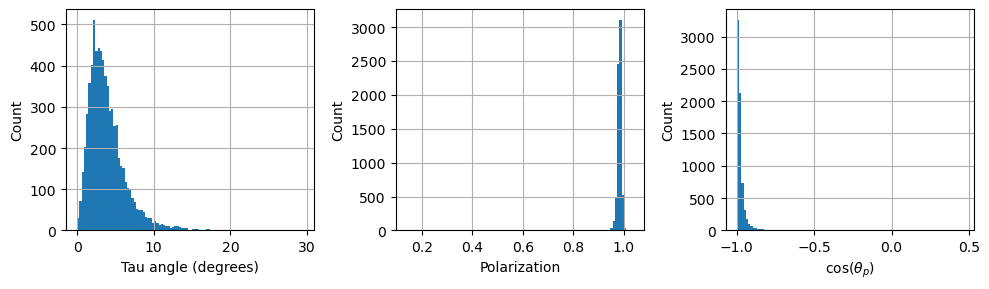

In [103]:
nucleon4m_stationary = vector.array({"E": nucleon4m.M, "px": np.zeros(nucleon4m.shape), "py": np.zeros(nucleon4m.shape), "pz": np.zeros(nucleon4m.shape)})

s = np.array(spin_vector(
    tau4m, 
    nutau4m, 
    nucleon4m_stationary, 
    "qel",
    # x=qel_events["x"].values,
    # W=qel_events["W"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

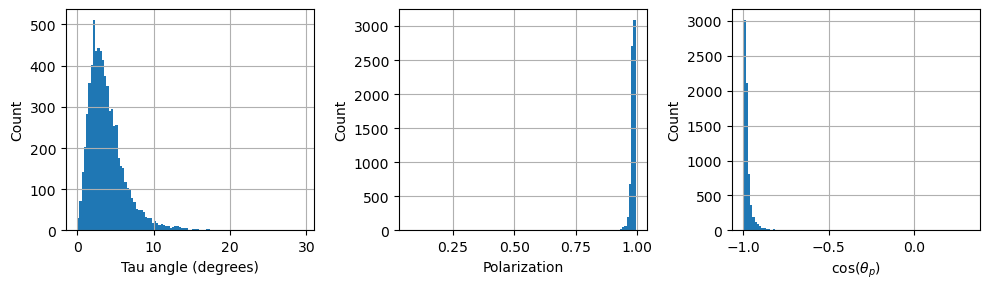

In [104]:
nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

s = np.array(spin_vector(
    tau4m_rotated, 
    nutau4m_rotated, 
    nucleon4m_rotated, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

In [105]:
nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, rotate_tau=False)

s2 = np.array(spin_vector(
    tau4m_rotated, 
    nutau4m_rotated, 
    nucleon4m_rotated, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)
assert np.allclose(s, s2)

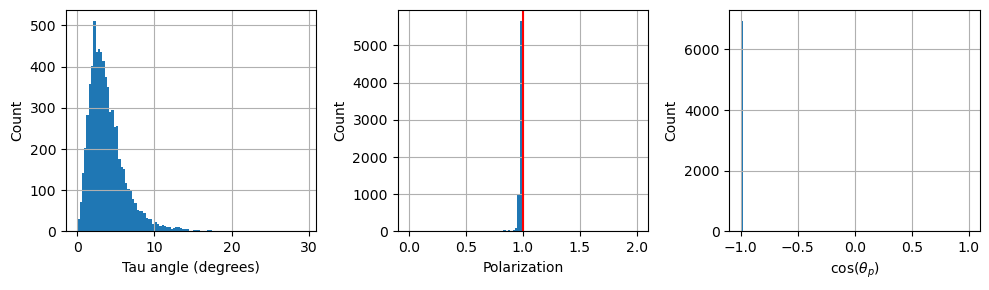

In [106]:
s = np.array(spin_vector2(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=np.linspace(0, 2, 100))
axs[1].set(xlabel="Polarization", ylabel="Count")
# axs[1].set(xscale="log")
axs[1].axvline(1, c="r")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

In some cases, I get a polarization vector that has magnitude > 1. Though this might not be completely incorrect, since the equations are not perfect and there might be some assumptions here and there that I break (e.g., they might always assume that the nucleon mass is 0.938 GeV, whereas that is not true and that is not the value that I pass to the code).
If $|s| > 1$, I can simply normalize the vector.

However, this is not a problem when using the spin vector equations from the tau polarization paper. Perhaps these equations are better?

## Resonance scattering

In [18]:
# Resonance scattering
# Delta mass
M_delta_res = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_Delta_0_res = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# This should not matter, as it is multiplied to all values and then divided away
kappa_res = 2/3
M_V_res = 0.84 # GeV. Maybe 0.84 GeV, see GiBUU thesis eq 5.24
C_V_3_0_res = 1.95 # Maybe 1.95, see GiBUU thesis eq 5.24

C_A_5_0_res = 1.2 # GiBUU thesis eq 5.27
C_0_res = {4: -0.3, 5: 1.2}
a_coeff_res = -1.21
b_coeff_res = 2 # GeV^2
M_A_res = 1.05 # GeV


def K(zeta, x, w, j, k, n):
    functions = {
        (3, 3, 3): lambda zeta, x, w: -2 * zeta**3 * (1 - 2*x)**2 * w**2 + 2 * zeta * (2 - 3*x) * w,
        (3, 3, 4): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (3, 3, 5): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w + 2 * (1 + zeta),
        (3, 4, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 - zeta) * (1 - 2*x) * w,
        (3, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**2,
        (3, 4, 5): lambda zeta, x, w: zeta * (1 - 2*x) * w,
        (3, 5, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w**2 - 2 * (1 - zeta) * w,
        (3, 5, 4): lambda zeta, x, w: zeta * (1 - 2*x) * w**2,
        (3, 5, 5): lambda zeta, x, w: zeta * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def A(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 - 2 * (1 - zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**2 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * w,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 + (1 + zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (1, 5, 5): lambda zeta, x, w: zeta * w + 1 + zeta,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 + zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 + 2 * (1 + zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w + 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 + 2 * zeta * (2 + zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w + zeta * (2 + zeta),
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 + zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 + 2 * (1 + zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 - 2 * (1 + zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta * (zeta * (1 + zeta) * (1 - 2*x) - 1) * w - 2 * (1 + zeta),
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (zeta * (1 + zeta) * (1 - 2*x)**2 + 2 * x) * w**2 + 2 * (1 + zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 + zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + x) * w + (1 + zeta)**2,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 + zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 + 2 * (1 + zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 - 4 * (1 + zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 2 * zeta**3 * w + 2 * zeta**2 * (1 + zeta),
        (5, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta**2 * (1 + zeta) * (1 - 2*x) * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)


def V(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 + 2 * (1 + zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * w**2,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 - (1 - zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**3 - (1 - zeta) * (1 - 4*x) * w**2,
        (1, 5, 5): lambda zeta, x, w: zeta * w**3 - (1 - zeta) * w**2,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 - 2 * (1 - zeta) * x * w,
        (2, 4, 5): lambda zeta, x, w: 4 * zeta * x * w**2 - 4 * (1 - zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x**2 * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * x * w**2 - 2 * (1 - zeta) * x * w,
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w - 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 - 2 * zeta * (2 - zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w**2 - zeta * (2 - zeta) * w,
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 - zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 - 2 * (1 - zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 + 2 * (1 - zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w**3 - zeta**2 * (1 - zeta) * w**2,
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**3 - 2 * zeta * (1 + zeta * (1 - zeta) * (1 - 2*x)) * w**2 + 2 * (1 - zeta) * w,
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 - zeta * (zeta * (1 - zeta) * (1 - 2*x)**2 - 2*x) * w**2 - 2 * (1 - zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 - zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 4 * zeta * w**2 - 4 * (1 - zeta) * w,
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 + 4 * (1 - zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * w**2 - 2 * (1 - zeta) * w,
        (5, 5, 6): lambda zeta, x, w: 4 * zeta**3 * (1 - 2*x) * x * w**3 - 4 * zeta * (zeta * (1 - zeta) * (1 - 2*x) + 1) * x * w**2 + 4 * (1 - zeta) * x * w,
    }

    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def C_V(q, W, M, j):
    if j == 3:
        # GiBUU thesis eq 5.24
        return C_V_3_0_res / (1 - q**2 / M_V_res**2)**2 / (1 - q**2 / (4*M_V_res**2))
    elif j == 4:
        # GiBUU thesis eq 5.23
        return - M / W * C_V(q, W, M, 3)
    elif j in {5, 6}:
        return np.zeros(q.shape)
    else:
        raise ValueError(f"Unsupported j = {j}")
    
def C_A(q, M, j):
    # Might also be different. See GiBUU thesis eq 5.28 - 5.30
    if j == 3:
        return np.zeros(q.shape)
    elif j == 6:
        return C_A(q, M, 5) * M**2 / (m_pi**2 - q**2)
    elif j == 5:
        return C_A_5_0_res / (1 - q**2 / M_A_res**2)**2 / (1 - q**2 / (3 * M_A_res**2))
    elif j == 4:
        return -C_A(q, M, 5) / 4
    else:
        raise ValueError(f"Unsupported j = {j}")

# def G_A_RS(q, M, j):
#     # TODO. See Rein-Seghal paper
#     (1-q**2 / (2*m))

def p_pi_star(W, M):
    return np.sqrt(((W**2 - M**2 + m_pi**2)/(2*W))**2 - m_pi**2)

def lambda_func(a, b, c):
    return a**2 + b**2 + c**2 - 2*(a*b + a*c + b*c)

def q_CM(W, M):
    q = (W**2 - m_pi**2 - M**2)**2 - 4*m_pi**2 * M**2
    q[q < 0] = 1
    return np.sqrt(q) / (2*W)

def Gamma_Delta(W, M):
    # NOTE according to GiBUU thesis, P-wave is more correct, as it preserves angular momentum, which S-waves do not. 
    #  This should however not affect my results, as this constant is divided away anyway.
    return Gamma_Delta_0_res * (q_CM(W, M) / q_CM(M_delta_res, M))**3
    
    # From tau polarization paper
    # return Gamma_Delta_0_res * M_delta_res / W * np.sqrt(lambda_func(W**2, M**2, m_pi**2) / lambda_func(M_delta_res**2, M**2, m_pi**2))
    
    # From lepton polarization paper, assuming S-waves (L=0).
    # return Gamma_Delta_0_res * (p_pi_star(W, M) / p_pi_star(M_delta_res, M))**3
    # Both of these seem to give the same result

def eta_delta_bw2(W, M, Gamma_Delta_f=Gamma_Delta):
    value = 1/(2*np.pi) * Gamma_Delta_f(W, M) / ((W**2 - M_delta_res**2)**2 + Gamma_Delta_f(W, M)**2 / 4)
    # If a nan value is encountered, set to 1 to not make the whole computation into nan. 
    # This is ok, because this value does not affect the final polarization anyway.
    value[np.isnan(value)] = 1
    return value

def Wnres(x, Q2, p, q, M, n, W):
    # The invariant mass of the Delta particle. 
    # This should be a sample from a Breit-Wigner distribution 
    # around the central mass M_Delta and with width Gamma_Delta
    # W = np.sqrt((p + q)**2)

    w_value = w(p, q, M)
    # x = Q2 / (2*p.dot(q))
    zeta = M / M_delta_res
    
    # Since the constants are the same for all Wnres terms, they will not affect the value of the polarization, as they are divided away. This means that 
    # kappa_res * np.cos(theta_c)**2 * M * M_delta_res * eta_delta_bw2(W, M) is meaningless. 
    if n == 3:
        return (
            2 * kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
            eta_delta_bw2(W, M) * 
            np.sum(
                [K(zeta, x, w_value, j, k, n) * C_V(q, W, M, j) * C_A(q, M, k)
                for j, k in itertools.product(range(3, 7), repeat=2)],
                axis=0
            )
        )
    
    return (
        kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
        eta_delta_bw2(W, M) * 
        np.sum(
            [V(zeta, x, w_value, j, k, n) * C_V(q, W, M, j) * C_V(q, W, M, k) 
            + A(zeta, x, w_value, j, k, n) * C_A(q, M, j) * C_A(q, M, k)
            for j, k in itertools.product(range(3, 7), repeat=2)],
            axis=0
        )
    )

In [7]:
res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

taus = res_particles[res_particles["pdg"] == 15]
nutaus = res_particles.groupby("event_num").nth(1)
assert np.all(nutaus["pdg"] == 16)

tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

nucleon4m = vector.array({"E": res_events["En"], "px": res_events["pxn"], "py": res_events["pyn"], "pz": res_events["pzn"]})
nucleon4m_stationary = vector.array({"E": np.zeros(taus.shape[0]) + 0.938919, "px": np.zeros(taus.shape[0]), "py": np.zeros(taus.shape[0]), "pz": np.zeros(taus.shape[0])})

nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

NameError: name 'particle_info' is not defined

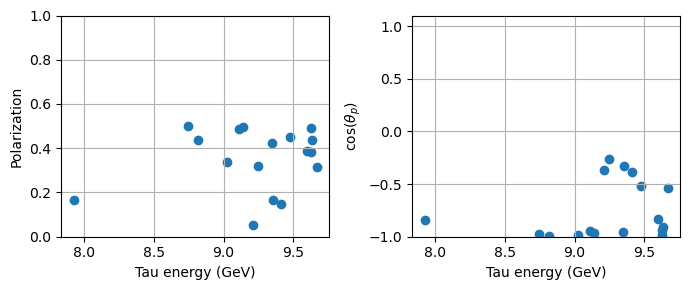

In [109]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.18

s = np.array(spin_vector(
    tau4m_rotated[zero_angle_tau_events], 
    nutau4m_rotated[zero_angle_tau_events], 
    nucleon4m_rotated[zero_angle_tau_events], 
    "res",
    x=res_events[zero_angle_tau_events.values]["xs"].values,
    W=res_events[zero_angle_tau_events.values]["Ws"].values
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This plot looks strange but the other plots look good.

In [110]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.03

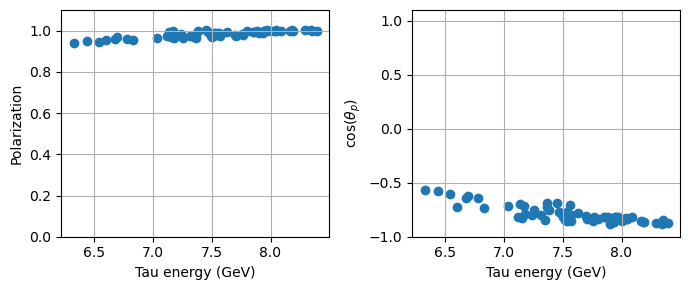

In [111]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.1
s = np.array(spin_vector(
    tau4m_rotated[almost10deg_tau_events], 
    nutau4m_rotated[almost10deg_tau_events], 
    nucleon4m_rotated[almost10deg_tau_events], 
    "res",
    x=res_events[almost10deg_tau_events.values]["xs"].values,
    W=res_events[almost10deg_tau_events.values]["Ws"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


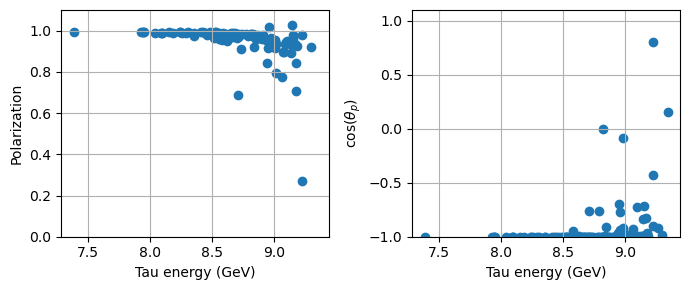

In [112]:
s = np.array(spin_vector2(
    tau4m[almost5deg_tau_events], 
    nutau4m[almost5deg_tau_events], 
    nucleon4m[almost5deg_tau_events], 
    "res",
    x=res_events[almost5deg_tau_events.values]["xs"].values,
    W=res_events[almost5deg_tau_events.values]["Ws"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


In [113]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.1

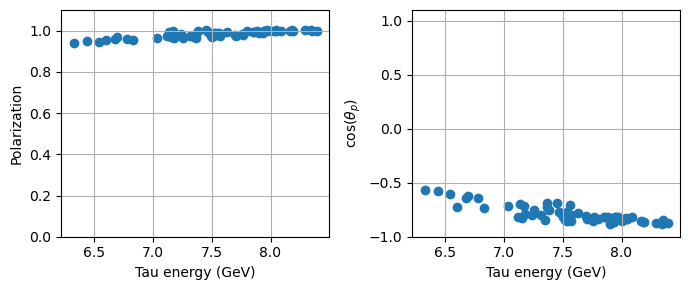

In [114]:
s = np.array(spin_vector(
    tau4m_rotated[almost10deg_tau_events], 
    nutau4m_rotated[almost10deg_tau_events], 
    nucleon4m_rotated[almost10deg_tau_events], 
    "res",
    x=res_events[almost10deg_tau_events.values]["xs"].values,
    W=res_events[almost10deg_tau_events.values]["Ws"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


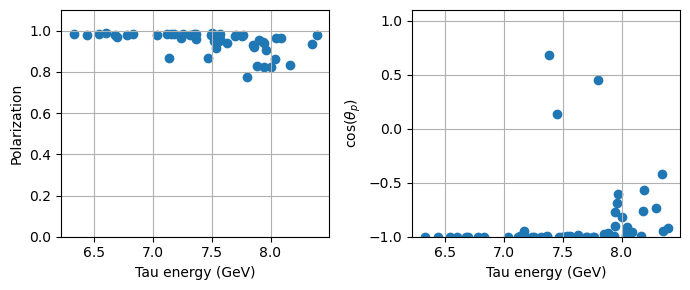

In [115]:
s = np.array(spin_vector2(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "res",
    x=res_events[almost10deg_tau_events.values]["xs"].values,
    W=res_events[almost10deg_tau_events.values]["Ws"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


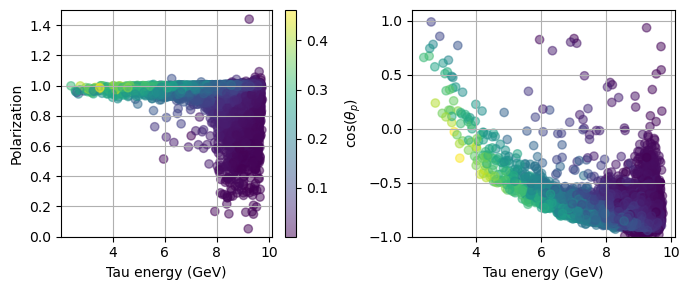

In [116]:
s = np.array(spin_vector(
    tau4m_rotated, 
    nutau4m_rotated, 
    nucleon4m_rotated, 
    "res",
    x=res_events["xs"].values,
    W=res_events["Ws"].values,
))

q = nutau4m - tau4m
W = res_events["Ws"]
x = res_events["xs"]

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
c = axs[0].scatter(tau4m.E, 2*np.linalg.norm(s, axis=0), c=tau_angles, alpha=0.5)
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.5))
fig.colorbar(c, ax=axs[0])
axs[1].scatter(tau4m.E, (s[1] / np.linalg.norm(s, axis=0)), c=tau_angles, alpha=0.5)
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


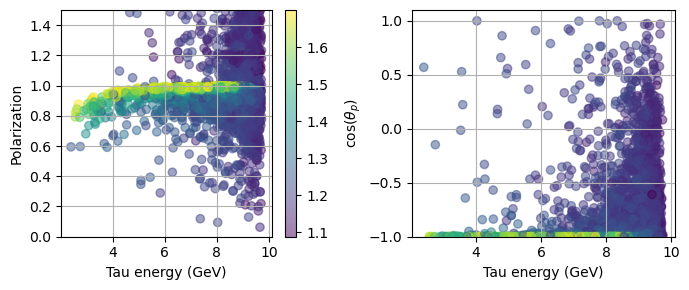

In [117]:
s = np.array(spin_vector2(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "res",
    x=res_events["xs"].values,
    W=res_events["Ws"].values,
))

q = nutau4m - tau4m
W = res_events["Ws"]
x = res_events["xs"]

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
c = axs[0].scatter(tau4m.E, 2*np.linalg.norm(s, axis=0), c=W, alpha=0.5)
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.5))
fig.colorbar(c, ax=axs[0])
axs[1].scatter(tau4m.E, (s[1] / np.linalg.norm(s, axis=0)), c=W, alpha=0.5)
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


In [118]:
assert np.isnan(s).sum() == 0

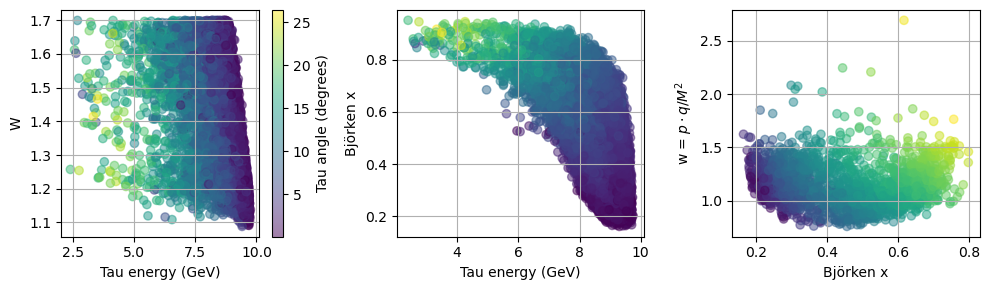

In [119]:
q = nutau4m - tau4m
W = res_events["Ws"]
x = res_events["xs"]
zeta = nucleon4m.M / M_delta_res
w_value = w(nucleon4m, q, nucleon4m.M)
E_9_events = np.abs(tau4m.E - 9) < 0.1

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")

c = axs[0].scatter(
    tau4m.E#[zero_angle_tau_events]
    , W, c=180/np.pi * tau_angles#[zero_angle_tau_events]
    , alpha=0.5)
axs[0].set(xlabel="Tau energy (GeV)", ylabel="W")
fig.colorbar(c, ax=axs[0], label="Tau angle (degrees)")

axs[1].scatter(
    tau4m.E#[zero_angle_tau_events]nucleon4m
    , x, c=180/np.pi * tau_angles#[zero_angle_tau_events]
    , alpha=0.5)
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"Björken x")

axs[2].scatter(
    x[E_9_events]
    , w_value[E_9_events]
    , c=180/np.pi * tau_angles[E_9_events]
    , alpha=0.5)
axs[2].set(xlabel="Björken x", ylabel=r"w = $p\cdot q/M^2$")

for ax in axs:
    ax.grid()


Check how many events have a small angle relative to the neutrino and is a resonance event. The polarization vector of these events do not match the figure in the tau polarization paper. If it is onlt a few number of events, it should not be a big problem.

In [53]:
for e in (5, 10, 20, 50, 100):
    events = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info.csv")
    taus = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv").query("pdg == 15")
    tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
    assert np.all(tau_angles > 0)
    n_bad_events = np.sum((np.abs(tau_angles) < 2) & events["res"])
    print(f"{e} GeV: {n_bad_events} bad events out of {events.shape[0]} events ({n_bad_events / events.shape[0] * 100:.2f}%)")

5 GeV: 138 bad events out of 17881 events (0.77%)
10 GeV: 260 bad events out of 42493 events (0.61%)
20 GeV: 216 bad events out of 56282 events (0.38%)
50 GeV: 112 bad events out of 66363 events (0.17%)
100 GeV: 75 bad events out of 70092 events (0.11%)


## Deep inelastic scattering

In [19]:
# Deep inelastic scattering
# The PDFs used in GENIE seems to bee CT10nlo, member 0 from LHAPDF. Source: https://github.com/GENIE-MC/Generator/blob/master/config/LHAPDF6.xml
# I should therefore probably use the same here
pdfset = lhapdf.mkPDF("CT10nlo", 0)
def pdf(quark, x, Q2):
    # Division by x might be wrong.
    # Probably does not have an effect on the result, since all PDFs are divided by the value
    f = pdfset.xfxQ2(quark, x, Q2) / x
    return np.array(f)


def mass_corrected_xi(x, Q2, charm):
    xi = x.copy()
    m_charm = 1.27 # GeV
    # If a charm quark is produced, replace x with xi
    xi[charm] = x[charm] / (Q2[charm] / (Q2[charm] + m_charm**2))
    # Cap the x to 1
    xi[xi > 1] = 1
    # print(xi)
    return xi

def W1dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdf(quark, xi, Q2) for quark in range(1, 7)], axis=0)
        - np.sum([pdf(quark, xi, Q2) for quark in range(-6, 0)], axis=0)
    )

def W4dis_pdf(x, Q2, p, q, M, charm):
    return 0

def W5dis_pdf(x, Q2, p, q, M, charm):
    # In the tau polarization paper, there is a factor of 2 in front. 
    xi = mass_corrected_xi(x, Q2, charm)
    
    # I am not sure if this is a mistake, convention difference, or something else
    return 1/w(p, q, M) * 2 * np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 


LHAPDF 6.5.4 loading /home/simon/miniconda3/envs/cern-skhep/share/LHAPDF/CT10nlo/CT10nlo_0000.dat
CT10nlo PDF set, member #0, version 4; LHAPDF ID = 11000


In [20]:
def W1dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdfvalues[quark] / x for quark in range(1, 7)], axis=0)
        - np.sum([pdfvalues[quark] / x for quark in range(-6, 0)], axis=0)
    )

def W4dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    return 0

def W5dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    
    return 1/w(p, q, M) * 2 * np.sum([pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 


In [21]:
def Wndis_f(x, Q2, p, q, M, charm, pdfvalues, n):
    if n == 1:
        xi = mass_corrected_xi(x, Q2, charm)
        return (1+xi/w(p, q, M)) * pdfvalues[f"F{n}"].values

    return 1/w(p, q, M) * pdfvalues[f"F{n}"].values

In [22]:
def get_pdf_values(dis_events):
    pdfvalues = {}

    assert dis_events.loc[:, "fuv":"fc"].notnull().all().all()

    pdfvalues["event_num"] = dis_events["event_num"]
    # down-quark
    pdfvalues[1] = (dis_events["fdv"] + dis_events["fds"]).values
    # up-quark
    pdfvalues[2] = (dis_events["fuv"] + dis_events["fus"]).values
    # strange-quark
    pdfvalues[3] = dis_events["fs"].values
    # charm-quark
    pdfvalues[4] = dis_events["fc"].values
    # bottom-quark
    pdfvalues[5] = np.zeros(dis_events.shape[0])
    # top-quark
    pdfvalues[6] = np.zeros(dis_events.shape[0])

    # dbar-quark
    pdfvalues[-1] = dis_events["fds"].values
    # ubar-quark
    pdfvalues[-2] = dis_events["fus"].values
    # sbar-quark
    pdfvalues[-3] = dis_events["fs"].values
    # cbar-quark
    pdfvalues[-4] = dis_events["fc"].values
    # bbar-quark
    pdfvalues[-5] = np.zeros(dis_events.shape[0])
    # tbar-quark
    pdfvalues[-6] = np.zeros(dis_events.shape[0])

    pdfvalues = pd.DataFrame(pdfvalues)

    return pdfvalues

In [31]:
dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]

dis_events = event_info[event_info["dis"]]

taus = dis_particles[dis_particles["pdg"] == 15]
nutaus = dis_particles.groupby("event_num").nth(1)

tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])


nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
# nucleon_mass = np.ones(nucleons.shape[0]) * 0.938919 #14.895082 / 16
# nucleon_mass[nucleons["pdg"] < 1e5] = nucleons[nucleons["pdg"] < 1e5]["E"]
nucleon4m = vector.array({"E": dis_events["En"], "px": dis_events["pxn"], "py": dis_events["pyn"], "pz": dis_events["pzn"]})
nucleon4m_stationary = vector.array({"E": 0.98318 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})

nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

pdfvalues = get_pdf_values(dis_events)

fvalues = dis_events.loc[:, "F1":"F5"]

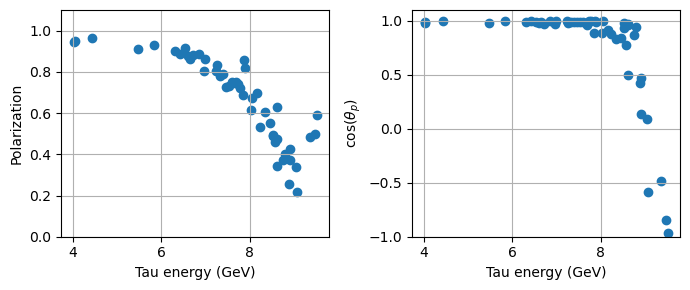

In [32]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(spin_vector(
    tau4m_rotated[zero_angle_tau_events], 
    nutau4m_rotated[zero_angle_tau_events], 
    nucleon4m_rotated[zero_angle_tau_events], 
    "dis_pdf",
    x=dis_events[zero_angle_tau_events.values]["xs"].values,
    W=dis_events[zero_angle_tau_events.values]["Ws"].values,
    charm=dis_events.loc[zero_angle_tau_events.values, "charm"].values,
    pdfvalues=fvalues[zero_angle_tau_events.values],
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


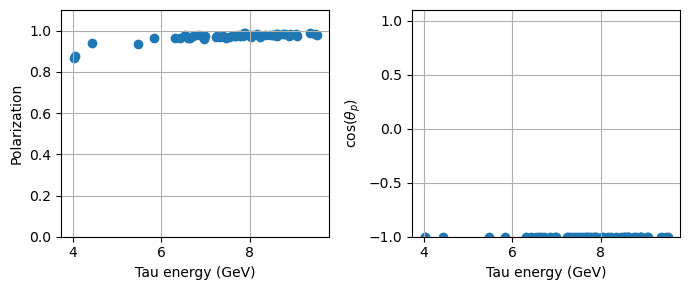

In [34]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(spin_vector2(
    tau4m_rotated[zero_angle_tau_events], 
    nutau4m_rotated[zero_angle_tau_events], 
    nucleon4m_rotated[zero_angle_tau_events], 
    "dis_pdf",
    x=dis_events[zero_angle_tau_events.values]["xs"].values,
    W=dis_events[zero_angle_tau_events.values]["Ws"].values,
    charm=dis_events.loc[zero_angle_tau_events.values, "charm"].values,
    pdfvalues=fvalues[zero_angle_tau_events.values],
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like it should! See tau polarization paper, figure 6, right column

In [35]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.03

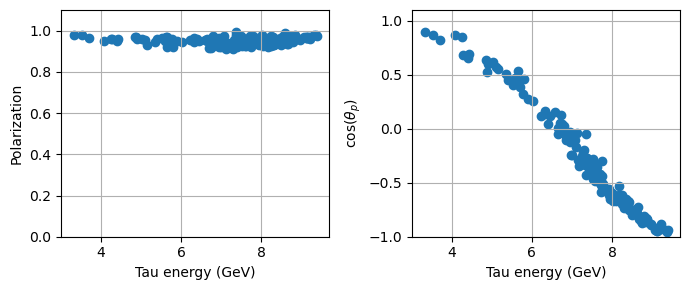

In [36]:
s = np.array(spin_vector(
    tau4m_rotated[almost5deg_tau_events], 
    nutau4m_rotated[almost5deg_tau_events], 
    nucleon4m_rotated[almost5deg_tau_events], 
    "dis_f",
    x=dis_events[almost5deg_tau_events.values]["xs"].values,
    W=dis_events[almost5deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost5deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost5deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


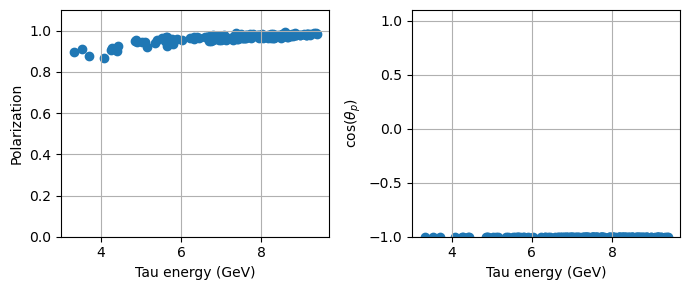

In [37]:
s = np.array(spin_vector2(
    tau4m_rotated[almost5deg_tau_events], 
    nutau4m_rotated[almost5deg_tau_events], 
    nucleon4m_rotated[almost5deg_tau_events], 
    "dis_f",
    x=dis_events[almost5deg_tau_events.values]["xs"].values,
    W=dis_events[almost5deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost5deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost5deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like Figure 6, center column in the tau polarization paper

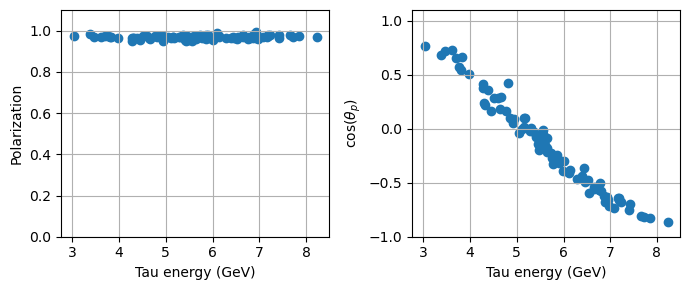

In [130]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(spin_vector(
    tau4m_rotated[almost10deg_tau_events], 
    nutau4m_rotated[almost10deg_tau_events], 
    nucleon4m_rotated[almost10deg_tau_events], 
    "dis_f",
    x=dis_events[almost10deg_tau_events.values]["xs"].values,
    W=dis_events[almost10deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost10deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost10deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


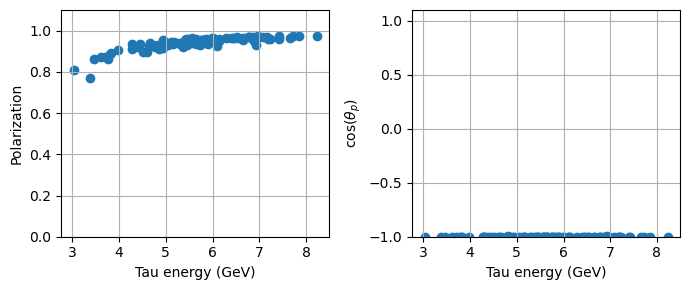

In [131]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(spin_vector2(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "dis_f",
    x=dis_events[almost10deg_tau_events.values]["xs"].values,
    W=dis_events[almost10deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost10deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost10deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This plot also looks exactly like it should! See tau polarization paper, figure 6, right column

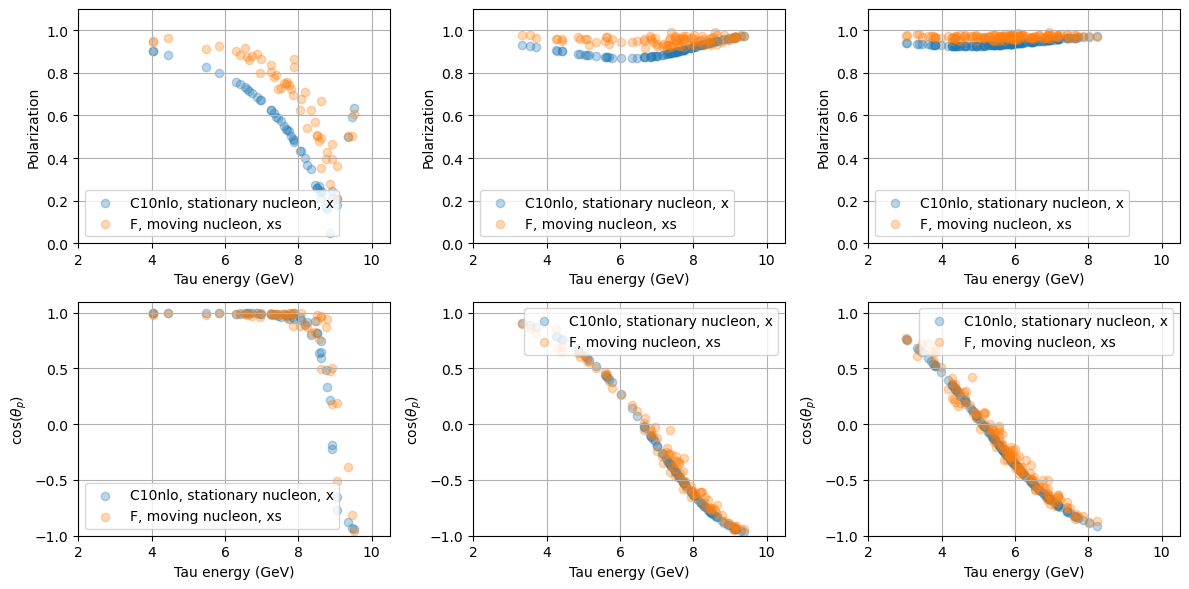

In [132]:
taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi

assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.02, 0.05)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]
    
    selected_particles = dis_particles[dis_particles["event_num"].isin(good_angle_events["event_num"])]
    selected_events = dis_events[dis_events["event_num"].isin(good_angle_events["event_num"])]
    
    selected_taus = selected_particles[selected_particles["pdg"] == 15]
    selected_nus = selected_particles.groupby("event_num").nth(1)
    
    tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
    nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
    
    nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})

    nucleon4m_stationary = vector.array({"E": 0.98318 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})
    
    nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

    selected_pdfvalues = pdfvalues[dis_events["event_num"].isin(good_angle_events["event_num"])]
    selected_fvalues = fvalues[dis_events["event_num"].isin(good_angle_events["event_num"])]

    for int_type, df, t4m, nu4m, nuc4m, x, label in (
        ("dis_pdf", None, tau4m, nutau4m, nucleon4m_stationary, selected_events["x"].values, "C10nlo, stationary nucleon, x"), 
        # ("dis_grv", selected_pdfvalues, nucleon4m_stationary, selected_events["x"].values, "GRV98lo, stationary nucleon, x"), 
        ("dis_f", selected_fvalues, tau4m_rotated, nutau4m_rotated, nucleon4m_rotated, selected_events["xs"].values, "F, moving nucleon, xs"),
        ):

        s = np.array(spin_vector(
            t4m, 
            nu4m,
            nuc4m,
            int_type,
            x=x,
            W=selected_events["Ws"].values,
            charm=selected_events["charm"].values,
            pdfvalues=df,
        ))

        ax_col[0].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=label, alpha=0.3)
        ax_col[1].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=label, alpha=0.3)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

## Combined plot
Plot all interaction types for the three different angles.

This is a recreation of Figure 6 in the tau polarization paper

In [52]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
dis_events = event_info[event_info["dis"]]
pdfvalues = get_pdf_values(dis_events)

taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.03, 0.1)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]

    for particles, events, int_type in zip((qel_particles, res_particles, dis_particles), (qel_events, res_events, dis_events), ("qel", "res", "dis_f")):
        selected_particles = particles[particles["event_num"].isin(good_angle_events["event_num"])]
        selected_events = events[events["event_num"].isin(good_angle_events["event_num"])]
        selected_taus = selected_particles[selected_particles["pdg"] == 15]
        selected_nus = selected_particles.groupby("event_num").nth(1)
        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
        nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})
        
        nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

        # nucleon4m = vector.array({"E": 0.938919 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})
        # nucleus = selected_particles.groupby("event_num").first()
        # nucleon4m = vector.array({"E": nucleus["E"], "px": nucleus["px"], "py": nucleus["py"], "pz": nucleus["pz"]})
        selected_fvalues = None

        if int_type == "dis_f":
            selected_fvalues = dis_events[events["event_num"].isin(good_angle_events["event_num"])].loc[:, "F1":"F5"]
        
        if int_type == "dis_grv":
            selected_fvalues = pdfvalues[events["event_num"].isin(good_angle_events["event_num"])]

        # print(int_type)
        s = np.array(spin_vector(
            tau4m_rotated, 
            nutau4m_rotated,
            nucleon4m_rotated,
            int_type,
            # x=selected_events["x"].values,
            # W=selected_events["W"].values,
            charm=selected_events["charm"].values,
            pdfvalues=selected_fvalues,
        ))
        if np.isnan(s).any():
            print(f"NaN: {angle=}, {int_type=}", np.isnan(s).sum(axis=1))

        ax_col[0].hist(tau4m.E, bins=np.linspace(0, 10, 30), histtype="step", label=int_type, lw=2, alpha=0.7)
        ax_col[1].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
        ax_col[2].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Counts (arbitrary units)")
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[2].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

fig.suptitle("Using nucleon 4-momentum")

KeyError: 'fuv'

Text(0.5, 0.98, 'Using nucleon 4-momentum')

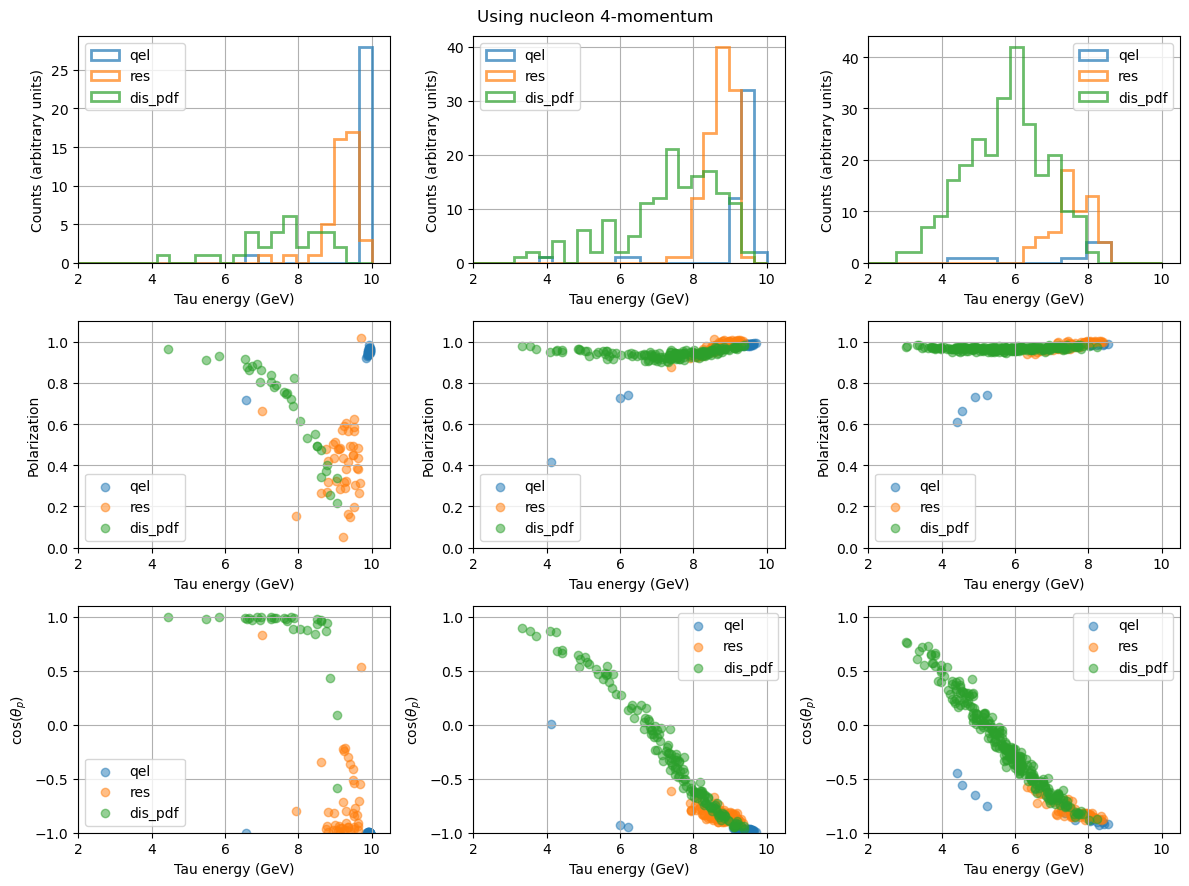

In [46]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
dis_events = event_info[event_info["dis"]]

taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.3, 0.03, 0.1)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]

    for particles, events, int_type in zip((qel_particles, res_particles, dis_particles), (qel_events, res_events, dis_events), ("qel", "res", "dis_pdf")):
        selected_particles = particles[particles["event_num"].isin(good_angle_events["event_num"])]
        selected_events = events[events["event_num"].isin(good_angle_events["event_num"])]
        selected_taus = selected_particles[selected_particles["pdg"] == 15]
        selected_nus = selected_particles.groupby("event_num").nth(1)
        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
        nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})
        
        # Boost all vectors such that the nucleon is at rest
        tau4m_boosted = tau4m.boostCM_of(nucleon4m)
        nucleon4m_boosted = nucleon4m.boostCM_of(nucleon4m)
        nutau4m_boosted = nutau4m.boostCM_of(nucleon4m)

        assert np.allclose(nucleon4m_boosted.px, 0)
        assert np.allclose(nucleon4m_boosted.py, 0)
        assert np.allclose(nucleon4m_boosted.pz, 0)

        # get the angles to rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
        phi = nutau4m_boosted.phi
        theta = nutau4m_boosted.theta

        # Rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
        nutau4m_rotated = nutau4m_boosted.rotateZ(-phi).rotateY(-theta)
        # Rotate all other momentum vectors, thereby preserving the 4-momentum conservation
        tau4m_rotated = tau4m_boosted.rotateZ(-phi).rotateY(-theta)
        nucleon4m_rotated = nucleon4m_boosted.rotateZ(-phi).rotateY(-theta)

        assert np.allclose(nutau4m_rotated.px, 0)
        assert np.allclose(nutau4m_rotated.py, 0)
        assert np.allclose(nutau4m_rotated.E, nutau4m_rotated.pz)

        assert np.allclose(nucleon4m_boosted.px, 0)
        assert np.allclose(nucleon4m_boosted.py, 0)
        assert np.allclose(nucleon4m_boosted.pz, 0)

        Q2_rotated = -(nutau4m_rotated - tau4m_rotated)**2
        assert np.allclose(-(nutau4m_rotated - tau4m_rotated)**2, -(nutau4m - tau4m)**2)

        selected_fvalues = None

        if int_type == "dis_f":
            selected_fvalues = fvalues[events["event_num"].isin(good_angle_events["event_num"])]
        
        if int_type == "dis_grv":
            selected_fvalues = pdfvalues[events["event_num"].isin(good_angle_events["event_num"])]

        # print(int_type)
        s = np.array(spin_vector(
            tau4m_rotated, 
            nutau4m_rotated,
            nucleon4m_rotated,
            int_type,
            # x=selected_events["x"].values,
            # W=selected_events["W"].values,
            charm=selected_events["charm"].values,
            pdfvalues=selected_fvalues,
        ))
        if np.isnan(s).any():
            print(f"NaN: {angle=}, {int_type=}", np.isnan(s).sum(axis=1))

        ax_col[0].hist(tau4m.E, bins=np.linspace(0, 10, 30), histtype="step", label=int_type, lw=2, alpha=0.7)
        ax_col[1].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
        ax_col[2].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Counts (arbitrary units)")
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[2].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

fig.suptitle("Using nucleon 4-momentum")

## Change all polarization vectors for IceCube events

Incoming neutrino energy: 5 GeV
Fraction of events with norm > 1: 0.23276103126223366
Incoming neutrino energy: 10 GeV
Fraction of events with norm > 1: 0.04068905466782764
Incoming neutrino energy: 20 GeV
Fraction of events with norm > 1: 0.011140329057247433
Incoming neutrino energy: 50 GeV
76 events are not qel, res or dis
Fraction of events with norm > 1: 0.002998658891249642
Incoming neutrino energy: 100 GeV
55 events are not qel, res or dis
Fraction of events with norm > 1: 0.0009844204759458996


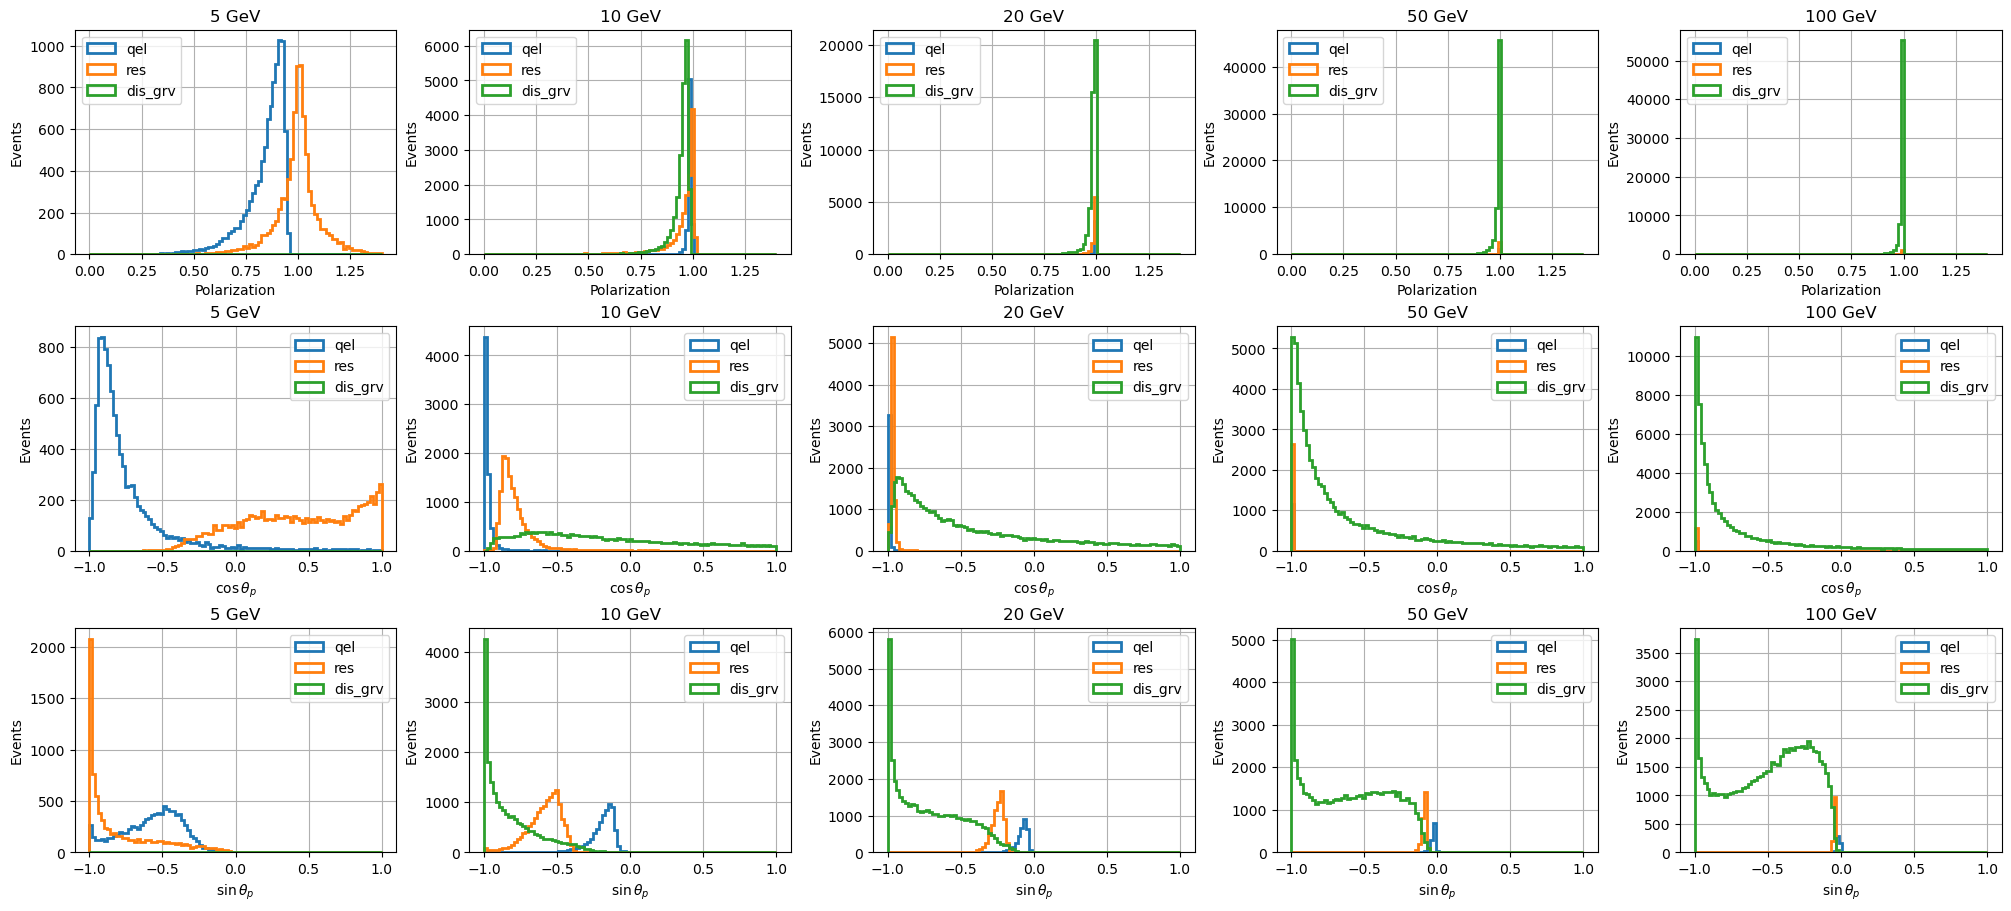

In [23]:
neutrino_energies = (5, 10, 20, 50, 100)
# Assume that the nucleon is stationary. This is an approximation that makes the polarizatio get the correct normalization.
# NOTE only works for dis_pdf, no other DIS settings
stationary = False

all_pols = {}
all_event_infos = {}

fig, axs = plt.subplots(nrows=3, ncols=len(neutrino_energies), figsize=(4*len(neutrino_energies), 9), layout="constrained")

for e, ax_col in zip(neutrino_energies, axs.T):
    # Load files
    particle_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv")
    event_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info_pdf.csv")
    all_event_infos[e] = event_info
    
    pols = pd.DataFrame() # columns=["polx", "poly", "polz", "event_num"]
    # TODO make this work with dis_f, not just dis_grv and dis_pdf
    for int_type in ("qel", "res", "dis_grv"):
        # Select qel, res and dis particles
        if int_type.find("_") != -1:
            int_type_col = int_type.split("_")[0]
        else:
            int_type_col = int_type

        events = event_info[event_info[int_type_col]]

        particles = particle_info[
            particle_info["event_num"]
            .isin(events.loc[events[int_type_col], "event_num"].values)
        ]

        selected_taus = particles[particles["pdg"] == 15]
        selected_nus = particles.groupby("event_num").nth(1)

        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})

        if stationary:
            x = events["x"].values
            W = events["W"].values
            nucleon4m = vector.array({"E": 0.938919 * np.ones(tau4m.shape[0]), "px": np.zeros(events.shape[0]), "py": np.zeros(events.shape[0]), "pz": np.zeros(events.shape[0])})
        else:
            x = events["xs"].values
            W = events["Ws"].values
            nucleon4m = vector.array({"E": events["En"], "px": events["pxn"], "py": events["pyn"], "pz": events["pzn"]})
        
        df = None
        if int_type == "dis_f":
            df = events.loc[:, "F1":"F5"]
        elif int_type == "dis_grv":
            df = get_pdf_values(events)

        # Rotate all vectors such that the nucleon is at rest
        nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m)

        s = np.array(spin_vector(
            tau4m_rotated,
            nutau4m_rotated,
            nucleon4m_rotated,
            int_type,
            x=x,
            W=W,
            charm=events["charm"].values,
            pdfvalues=df,
        ))

        p = 2 * np.linalg.norm(s, axis=0)
        # Set maximum polarization to 1
        # ax_col[0].hist(p, bins=np.linspace(0, 2, 100), label=int_type, alpha=0.3)
        # ax_col[1].hist(s[1] / np.linalg.norm(s, axis=0), bins=np.linspace(-1, 1, 100), label=int_type, alpha=0.3)
        ax_col[0].hist(p, bins=np.linspace(0, 1.4, 100), label=int_type, histtype="step", linewidth=2)
        ax_col[1].hist(s[1] / np.linalg.norm(s, axis=0), bins=np.linspace(-1, 1, 100), label=int_type, histtype="step", linewidth=2)
        ax_col[2].hist(s[0] / np.linalg.norm(s, axis=0), bins=np.linspace(-1, 1, 100), label=int_type, histtype="step", linewidth=2)
        # Transfer the polarization vector to the lab frame
        # s[1] should be along the tau momentum direction.
        # Project the first component of the polarization vector onto the plane of the tau lepton and the neutrino
        # The second component should be in the tau neutrino-tau lepton plane, orthogonal to the tau and the tau-tau neutrino plane normal
        pol_l = vector.MomentumNumpy3D(tau4m) * 2 * s[1] / tau4m.p
        transverse_direction = vector.MomentumNumpy3D(nutau4m).cross(vector.MomentumNumpy3D(tau4m)).cross(vector.MomentumNumpy3D(tau4m))
        pol_t = transverse_direction * 2 * s[0] / transverse_direction.p
        pol_vec = pol_l + pol_t
        # Check that the longitudinal and transverse components are orthogonal
        assert np.allclose(pol_l.dot(pol_t), 0)
        # Check that the angle between the tau momentum and the polarization vector is the same as theta_p
        assert np.allclose(tau4m.deltaangle(pol_vec), np.arccos(s[1] / np.linalg.norm(s, axis=0)))

        new_pols = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": pol_vec.px, "poly": pol_vec.py, "polz": pol_vec.pz})
        
        # Concatenate the data with the pols dataframe
        pols = pd.concat([pols, new_pols])
    
    # Fill in the missing polarizations with 0, i.e. assume that they are unpolarized.
    events_not_in_pols = event_info.loc[~event_info["event_num"].isin(pols["event_num"].values), "event_num"].unique()
    
    # TODO for other interactions (which in practice is just coherent scattering), we assume unpolarized (or fully left-handed is a better approximation perhaps?)
    pols = pd.concat([pols, pd.DataFrame({"event_num": events_not_in_pols, "polx": np.zeros(events_not_in_pols.shape[0]), "poly": np.zeros(events_not_in_pols.shape[0]), "polz": np.zeros(events_not_in_pols.shape[0])})])
    print(f"Incoming neutrino energy: {e} GeV")
    if events_not_in_pols.shape[0] > 0:
        print(events_not_in_pols.shape[0], "events are not qel, res or dis")
    
    print("Fraction of events with norm > 1:", (np.linalg.norm(pols[["polx", "poly", "polz"]], axis=1) > 1).sum() / pols.shape[0])
    
    # Fill up nan values. In practice, this should never happen
    if pols["polz"].isnull().any():
        print("Number of NaN values:", pols["polz"].isnull().sum())
        pols = pols.fillna(0)
        
    pols = pols.sort_values("event_num")
    
    all_pols[e] = pols

    # uncomment this once I am confident that the code works
    # pols.to_csv(f"../data/NuTau_{e}.0_GeV_tau-b.csv", index=False)

    ax_col[0].set(title=f"{e} GeV", xlabel="Polarization", ylabel="Events", # yscale="log",
    )
    ax_col[1].set(title=f"{e} GeV", xlabel=r"$\cos\theta_p$", ylabel="Events")
    ax_col[2].set(title=f"{e} GeV", xlabel=r"$\sin\theta_p$", ylabel="Events")
    
for ax in axs.flat:
    ax.grid(True)
    ax.legend()

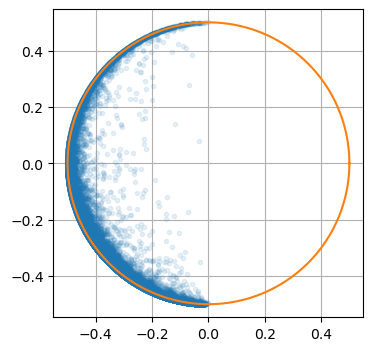

In [13]:
# Plot the s[0] and s[1] distributions
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(s[0, :], s[1, :], ".", alpha=0.1)
ax.grid(True)
ax.axis("equal")
theta = np.linspace(0, 2*np.pi, 1000)
ax.plot(np.cos(theta)/2, np.sin(theta)/2)

## Create files with fully left-handed polarization, set in the lab frame
This is used to test that the boosting works as expected in Tauola

In [3]:
neutrino_energies = (5, 10, 20, 50, 100)

all_pols = {}
all_event_infos = {}

for e in neutrino_energies:
    # Load files
    particle_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv")
    
    selected_taus = particle_info[particle_info["pdg"] == 15]
    p = np.sqrt(selected_taus["px"]**2 + selected_taus["py"]**2 + selected_taus["pz"]**2)
    pols = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": -selected_taus["px"] / p, "poly": -selected_taus["py"] / p, "polz": -selected_taus["pz"] / p})
    
    all_pols[e] = pols
    
    # uncomment this once I am confident that the code works
    pols.to_csv(f"../data/NuTau_{e}.0_GeV_tau_lab_lpol.csv", index=False)


In [60]:
def compare_fractions(problematic_events, ev, col):
    combined_comparison = pd.concat([problematic_events[col].value_counts() / problematic_events.shape[0], ev[col].value_counts() / ev.shape[0]], axis=1)
    combined_comparison.columns = ["Problematic events", "All DIS events"]
    return combined_comparison


In [80]:
e_to_investigate = 50
P = np.sqrt((all_pols[e_to_investigate].loc[:, "polx":"polz"]**2).sum(axis=1))

print((P > 1.001).sum() / P.shape[0])

ev = all_event_infos[e_to_investigate].query("dis == True")

problematic_pols = all_pols[e_to_investigate]["event_num"][P.values > 1.001].values
problematic_events = ev.loc[ev["event_num"].isin(problematic_pols), :]

print(compare_fractions(problematic_events, ev, "charm"))
print(compare_fractions(problematic_events, ev, "hitqrk"))
print(compare_fractions(problematic_events, ev, "hitnuc"))
print(compare_fractions(problematic_events, ev, "sea"))
print(compare_fractions(problematic_events, ev, "atom"))

0.01925771890963338
       Problematic events  All DIS events
charm                                    
False                 1.0        0.939764
True                  NaN        0.060236
        Problematic events  All DIS events
hitqrk                                    
-2                0.999218        0.025429
 1                0.000782        0.955912
 3                     NaN        0.018660
        Problematic events  All DIS events
hitnuc                                    
2112              0.531299        0.632297
2212              0.468701        0.367703
       Problematic events  All DIS events
sea                                      
True             0.999218        0.117559
False            0.000782        0.882441
      Problematic events  All DIS events
atom                                    
16              0.910798        0.924562
1               0.089202        0.075438


In [78]:
(problematic_events["hitqrk"] == -2).sum(), (ev["hitqrk"] == -2).sum()

(1903, 2295)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


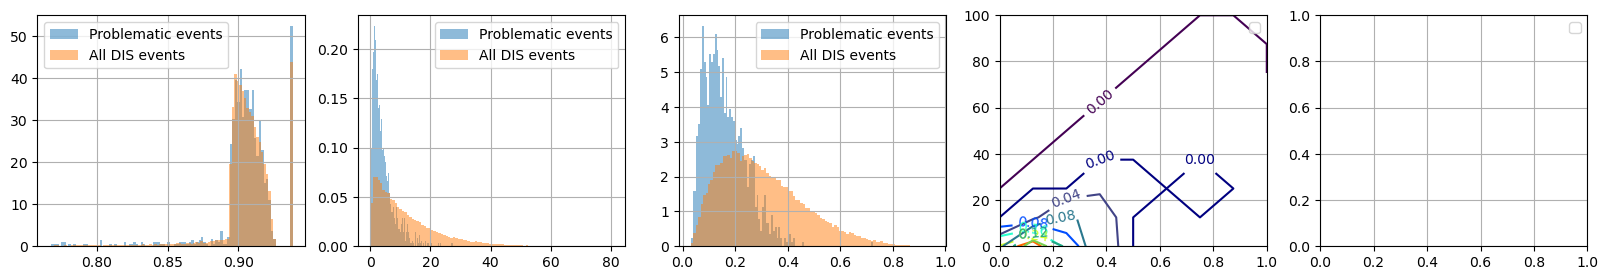

In [81]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 3))
axs[0].hist(problematic_events["Mnuc"], bins=100, density=True, alpha=0.5, label="Problematic events")
axs[0].hist(ev["Mnuc"], bins=100, density=True, alpha=0.5, label="All DIS events")

axs[1].hist(problematic_events["Q2s"], bins=100, density=True, alpha=0.5, label="Problematic events")
axs[1].hist(ev["Q2s"], bins=100, density=True, alpha=0.5, label="All DIS events")

axs[2].hist(problematic_events["xs"], bins=100, density=True, alpha=0.5, label="Problematic events")
axs[2].hist(ev["xs"], bins=100, density=True, alpha=0.5, label="All DIS events")

levels = 5

counts, xbins, ybins = np.histogram2d(problematic_events["xs"], problematic_events["Q2s"], bins=(np.linspace(0, 1, 10), np.linspace(0, 100, 10)), density=True)
cm = axs[3].contour(counts.T, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], levels=levels, cmap="jet")
axs[3].clabel(cm, inline=1, fontsize=10)

counts, xbins, ybins = np.histogram2d(ev["xs"], ev["Q2s"], bins=(np.linspace(0, 1, 10), np.linspace(0, 100, 10)), density=True)
cm = axs[3].contour(counts.T, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], levels=levels)
axs[3].clabel(cm, inline=1, fontsize=10)

# axs[3].contour(problematic_events["xs"], problematic_events["Q2s"], bins=(100, 100), density=True, label="Problematic events")
# axs[4].hist2d(ev["xs"], ev["Q2s"], bins=(100, 100), density=True, label="All DIS events")

for ax in axs.flat:
    ax.grid(True)
    ax.legend()

In [ ]:
tau_xy_vec = vector.array({"px": tau4m["px"], "py": tau4m["py"], "pz": np.zeros(tau4m.shape[0])})
tau_xy_unit = tau_xy_vec / tau_xy_vec.p
tau_xy_pol_component = tau_xy_unit * s[0] * 2 # Multiply by 2 since the spin vector is 1/2

In [14]:
boost_vector = tau4m.to_beta3()

# Boost tau, nucleon and neutrino such that the tau has no y component, since they seem to assume that there is no y component
nutau4m_boosted = nutau4m.boostY(beta=-boost_vector.py)
tau4m_boosted = tau4m.boostY(beta=-boost_vector.py)
nucleon4m_boosted = nucleon4m.boostY(beta=-boost_vector.py)

In [18]:
tau4m

MomentumNumpy4D([(-1.2338951 ,  2.0847654 , 12.95687391, 13.30061708),
                 ( 2.16904728, -3.59839538, 54.22635835, 54.41790371),
                 (-2.52368935, -2.22278992, 25.093773  , 25.38039274), ...,
                 (-1.68378653,  0.36064209, 89.29585567, 89.33013002),
                 (-0.63250094,  1.70642457, 14.99831163, 15.21244173),
                 ( 1.70943227, -1.16492854, 76.33218504, 76.38087967)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

In [19]:
tau4m_boosted

MomentumNumpy4D([(-1.2338951 ,  0.00000000e+00, 12.95687391, 13.13621589),
                 ( 2.16904728,  0.00000000e+00, 54.22635835, 54.29880105),
                 (-2.52368935,  0.00000000e+00, 25.093773  , 25.2828705 ), ...,
                 (-1.68378653,  0.00000000e+00, 89.29585567, 89.32940202),
                 (-0.63250094, -2.22044605e-16, 14.99831163, 15.11643141),
                 ( 1.70943227,  0.00000000e+00, 76.33218504, 76.37199566)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

In [20]:
nutau4m_boosted

MomentumNumpy4D([(0., -15.87036495, 100., 101.25151102),
                 (0.,   6.62702547, 100., 100.21934677),
                 (0.,   8.79168336, 100., 100.38572456), ...,
                 (0.,  -0.4037216 , 100., 100.00081495),
                 (0., -11.28854107, 100., 100.63513879),
                 (0.,   1.52533468, 100., 100.01163255)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

In [21]:
nucleon4m_boosted

MomentumNumpy4D([( 0.07527439, -0.1294181 , -0.11811676, 0.93206348),
                 (-0.07808244,  0.00636451, -0.11353036, 0.92151547),
                 ( 0.12112812,  0.02040973,  0.1013726 , 0.92335257), ...,
                 (-0.15908593,  0.00348367, -0.07753173, 0.92500014),
                 (-0.02785843, -0.19258587,  0.0913067 , 0.93907519),
                 (-0.13976922,  0.16764041, -0.12725465, 0.92422862)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

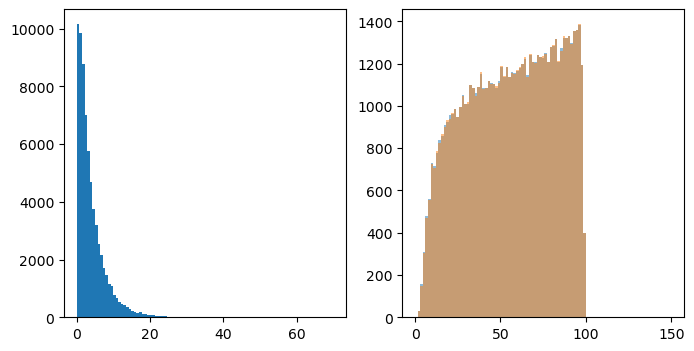

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
axs[0].hist(nutau4m_boosted.pt, bins=np.linspace(0, 70, 100))
c0, *_ = axs[1].hist(tau4m_boosted.p, bins=np.linspace(0, 150, 100), alpha=0.5)
c, *_ = axs[1].hist(tau4m.p, bins=np.linspace(0, 150, 100), alpha=0.5)

In [22]:
s = np.array(polarization_vector(
    tau4m_boosted, nutau4m_boosted, nucleon4m_boosted, 
    "dis_f", 
    x=events["xs"].values, 
    W=events["Ws"].values, 
    charm=events["charm"].values, 
    pdfvalues=events.loc[:, "F1":"F5"],
))
p = 2 * np.linalg.norm(s, axis=0)
costheta = s[1] / np.linalg.norm(s, axis=0)

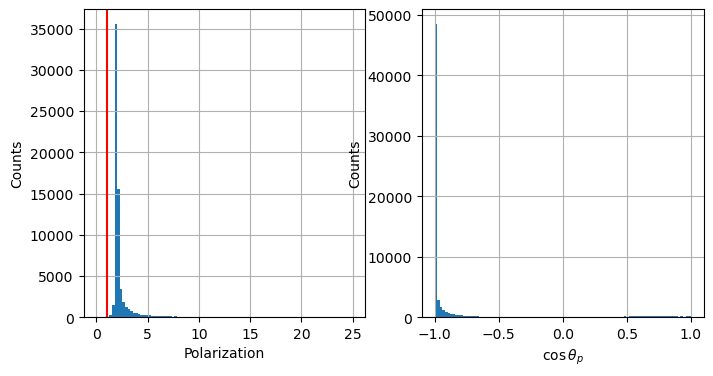

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
axs[0].hist(p, bins=np.linspace(0, 25, 100))
axs[0].set(xlabel="Polarization", ylabel="Counts")
axs[0].axvline(1, c="r")
axs[1].hist(costheta, bins=np.linspace(-1, 1, 100))
axs[1].set(xlabel=r"$\cos\theta_p$", ylabel="Counts")

for ax in axs:
    ax.grid(True)

## Load my own GENIE events
For testing and evaluating W and Q2 values, I will use my own GENIE events.

In [82]:
import uproot

with uproot.open("../data/gntp.0.gst.root") as f:
    tree = f["gst"]
    qel = tree["qel"].array()
    res = tree["res"].array()
    dis = tree["dis"].array()
    cc = tree["cc"].array()
    taus = vector.array({"E": tree["El"].array(), "px": tree["pxl"].array(), "py": tree["pyl"].array(), "pz": tree["pzl"].array()})
    Q2 = tree["Q2s"].array()
    W = tree["Ws"].array()
    Ev = tree["Ev"].array()
    charm = tree["charm"].array()
    resid = tree["resid"].array()
    nucleons = vector.array({"E": tree["En"].array(), "px": tree["pxn"].array(), "py": tree["pyn"].array(), "pz": tree["pzn"].array()}) 
    xs = tree["xs"].array()

nutaus = vector.array({"E": Ev, "px": np.zeros(len(Ev)), "py": np.zeros(len(Ev)), "pz": Ev})

In [83]:
q = nutaus - taus
M = -q.E + np.sqrt(W**2 + q.px**2 + q.py**2 + q.pz**2)

[Text(0.5, 0, 'Nucleon pz (GeV)'), Text(0, 0.5, 'Counts')]

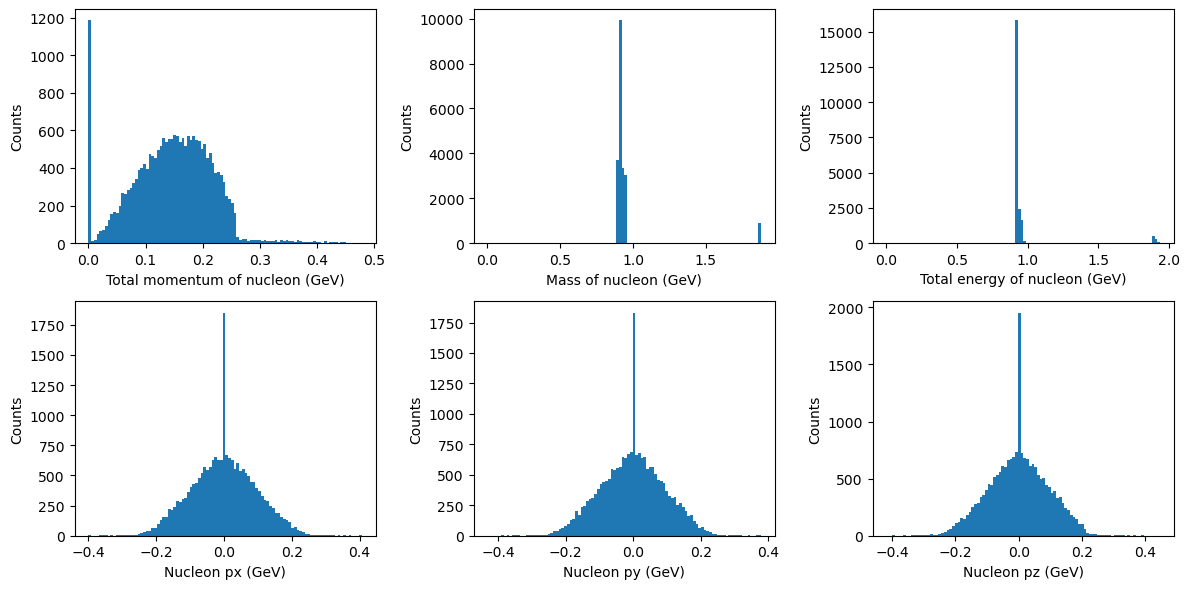

In [84]:
# Plot total momentum of nucleon, mass of nucleon and total energy of nucleon in separate subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), layout="tight")
axs[0, 0].hist(nucleons[cc].p, bins=100)
axs[0, 0].set(xlabel="Total momentum of nucleon (GeV)", ylabel="Counts")
axs[0, 1].hist(nucleons[cc].M, bins=100)
axs[0, 1].set(xlabel="Mass of nucleon (GeV)", ylabel="Counts")
axs[0, 2].hist(nucleons[cc].E, bins=100)
axs[0, 2].set(xlabel="Total energy of nucleon (GeV)", ylabel="Counts")

axs[1, 0].hist(nucleons[cc].px, bins=100)
axs[1, 0].set(xlabel="Nucleon px (GeV)", ylabel="Counts")
axs[1, 1].hist(nucleons[cc].py, bins=100)
axs[1, 1].set(xlabel="Nucleon py (GeV)", ylabel="Counts")
axs[1, 2].hist(nucleons[cc].pz, bins=100)
axs[1, 2].set(xlabel="Nucleon pz (GeV)", ylabel="Counts")


In [79]:
np.sum(np.isclose((Q2 / (W**2 + Q2 - nucleons.M**2))[cc], xs[cc], atol=1e-1))

17942

In [77]:
(Q2 / (W**2 + Q2 - nucleons.M**2))[cc], xs[cc]

(<Array [0.571, 0.123, 0.834, ..., 0.41, 0.204, 0.352] type='20955 * float64'>,
 <Array [0.571, 0.123, 0.834, ..., 0.41, 0.686, 0.352] type='20955 * float64'>)

In [87]:
(Q2 / (2*nucleons.dot(q)))[cc], xs[cc]

(<Array [0.571, 0.113, 0.834, ..., 0.41, 1.8, 0.352] type='20955 * float64'>,
 <Array [0.571, 0.123, 0.834, ..., 0.41, 0.686, 0.352] type='20955 * float64'>)

In [152]:
atan_angle = np.arctan(np.sqrt(taus.px **2 + taus.py**2) / taus.pz)
deltaangle = nutaus.deltaangle(taus)
assert np.allclose(np.arctan2(np.sqrt(taus.px**2 + taus.py**2), taus.pz), nutaus.deltaangle(taus))

vec2d = vector.array({"x": taus.pz, "y": np.sqrt(taus.px**2 + taus.py**2)})
assert np.allclose(vec2d.phi, deltaangle)

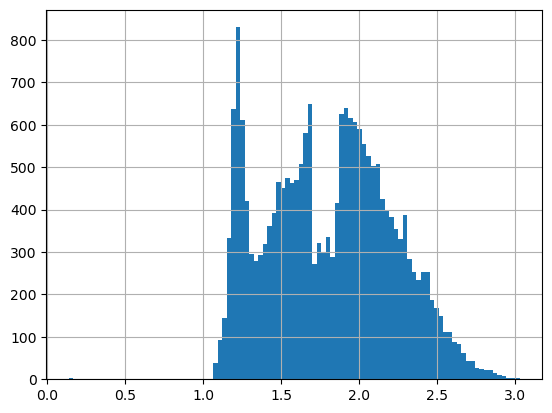

In [73]:
# W2 = (M + q.E)**2 - q.px**2 - q.py**2 - q.pz**2
plt.hist(W[cc], bins=100)
plt.grid()

In [74]:
np.sum(W > 2) / len(W)

0.50026

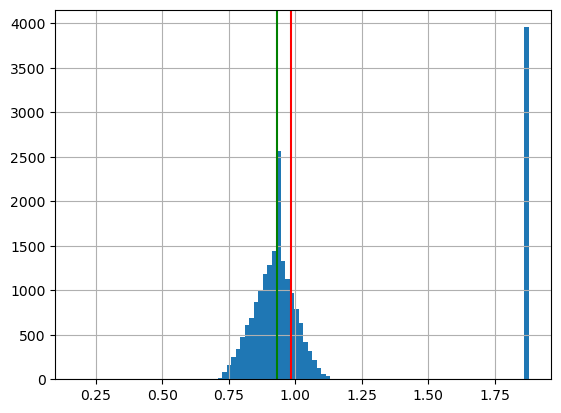

In [75]:
plt.hist(M[cc], bins=100)
plt.grid()
plt.axvline(0.983, c="r")
plt.axvline(14.895082 / 16, c="g")

In [77]:
np.sum(Q2 < 0)

12

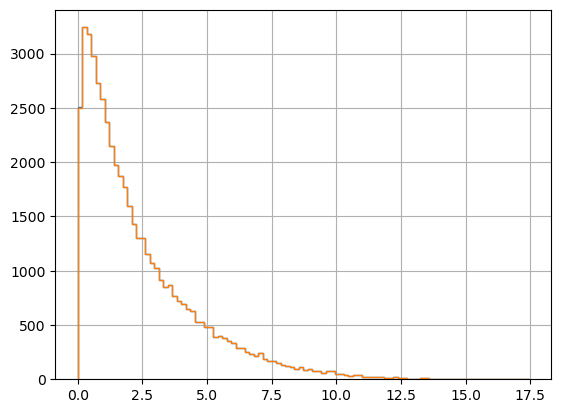

In [81]:
q2 = np.array(Q2)
q2[q2 < 0] = np.nan
plt.hist(-q**2, bins=100, histtype="step")
plt.hist(q2, bins=100, histtype="step")
plt.grid()

Q2s, Q2 and `-q**2` follow each other perfectly. This is a good cross-check. This means that I can safely use `-q**2` everywhere. 

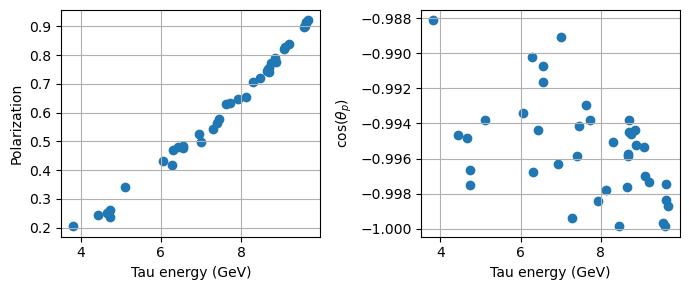

In [55]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = dis & cc & ((tau_angles * 180/np.pi) < 0.5)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


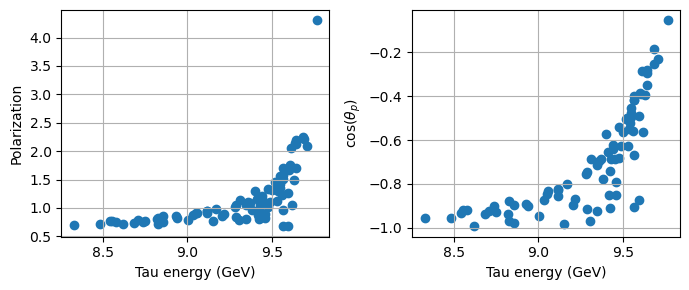

In [94]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = res & cc & ((tau_angles * 180/np.pi) < 1)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "res",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


This plot looks just as weird. It is likely something wrong with the code.

In [260]:
event_info.loc[:, :"sea"]

,event_num,cc,dis,qel,res,nuel,coh,dfr,imd,xsec,diffxsec,hitnuc,hitqrk,sea
0,0,True,False,False,True,False,False,False,False,1.379589,1.309489,2112,0,False
1,1,True,True,False,False,False,False,False,False,10.824815,64.840946,2112,1,False
2,2,True,False,False,True,False,False,False,False,4.135627,0.047385,2212,0,False
3,3,True,True,False,False,False,False,False,False,10.824815,50.882509,2112,1,False
4,4,True,False,True,False,False,False,False,False,4.986601,0.168885,2112,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42488,42488,True,False,False,True,False,False,False,False,4.135627,5.167240,2212,0,False
42489,42489,True,True,False,False,False,False,False,False,10.824815,53.463345,2112,1,False
42490,42490,True,True,False,False,False,False,False,False,10.824815,56.063451,2112,1,False
42491,42491,True,True,False,False,False,False,False,False,10.824815,7.772559,2112,1,False


## Plot GRV98LO PDF

In [255]:
pdf = pd.read_csv("../data/crv98lo.csv")
bypdf = pd.read_csv("../data/bypdf.csv")

<Axes: xlabel='x', ylabel='PDF'>

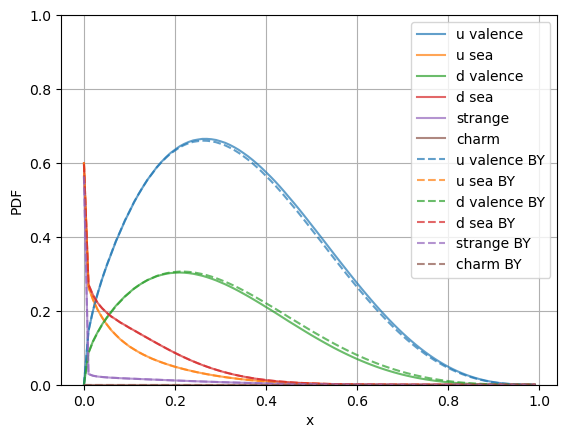

In [256]:
fig, ax = plt.subplots()

# Get the first 6 colors from the default line color sequence
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]

pdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], color=colors, ylim=(0, 1), label=["u valence", "u sea", "d valence", "d sea", "strange", "charm"], ylabel="PDF", grid=True, alpha=0.7, ax=ax)
bypdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], color=colors, ls="dashed", ylim=(0, 1), label=["u valence BY", "u sea BY", "d valence BY", "d sea BY", "strange BY", "charm BY"], ylabel="PDF", grid=True, alpha=0.7, ax=ax)

<Axes: xlabel='x', ylabel='x*PDF'>

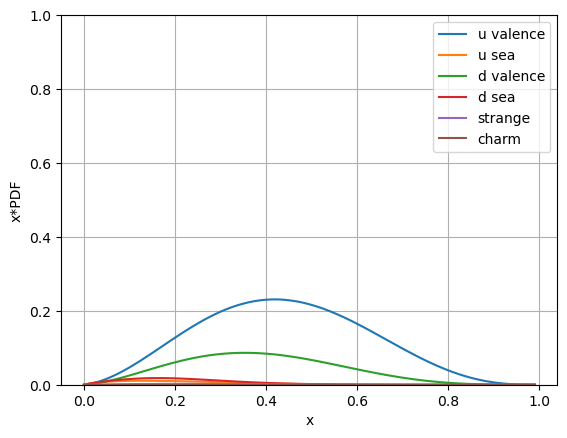

In [246]:
xpdf = pdf.copy()
xpdf[["fuv", "fus", "fdv", "fds", "fs", "fc"]] = xpdf[["fuv", "fus", "fdv", "fds", "fs", "fc"]] * xpdf["x"].values[:, np.newaxis]
xpdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], ylim=(0, 1), label=["u valence", "u sea", "d valence", "d sea", "strange", "charm"], grid=True, ylabel="x*PDF")

# Test different x and y polarizations
This is to determine how these components affect the decays, or if they have any effect at all.

In [7]:
import sys
sys.path.append("../")
from utils import load_hepmc

In [ ]:
# Write events
e = 5

# Load files
particle_info = pd.read_csv(f"../data/test_bare_lepton_toy_Tau_000005_{e}.0_GeV_particles_extended.csv")

selected_taus = particle_info[particle_info["pdg"] == 15]
selected_nus = particle_info.groupby("event_num").nth(1)
nevents = selected_taus["event_num"].shape[0]
pols = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": np.zeros(nevents), "poly": -0.5 * np.ones(nevents), "polz": -np.sqrt(1 - 0.5**2) * np.ones(nevents)})
pols2 = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": -0.5 * np.ones(nevents), "poly": np.zeros(nevents), "polz": -np.sqrt(1 - 0.5**2) * np.ones(nevents)})
pols3 = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": np.zeros(nevents), "poly": np.zeros(nevents), "polz": -np.ones(nevents)})

pols.to_csv(f"../data/test_pol_{e}.0_GeV_1.csv", index=False)
pols2.to_csv(f"../data/test_pol_{e}.0_GeV_2.csv", index=False)
pols3.to_csv(f"../data/test_pol_{e}.0_GeV_3.csv", index=False)

In [8]:
# Load simulated decays events
poly = load_hepmc(f"../data/test_pol_{e}.0_GeV_1.dat")
polx = load_hepmc(f"../data/test_pol_{e}.0_GeV_2.dat")
polz = load_hepmc(f"../data/test_pol_{e}.0_GeV_3.dat")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [45]:
def tau_visible_e(df) -> np.ndarray:
    return df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)").groupby("event_num")["E"].sum()

def visible_theta(df) -> np.ndarray:
    """The angle between the combined 4-momentum of the visible particles and the z axis"""
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    p = np.sqrt(
        (
            visible_decay_products.groupby("event_num")[["px", "py", "pz"]]
            .sum() # Sum over all decay products
            **2 # Square each component
        ).sum(axis=1) # Sum over the components
    ) # Sqrt of the sum
    pz = visible_decay_products.groupby("event_num")["pz"].sum()
    return np.arccos(pz / np.sqrt(p**2))

def tau_visible_cosphi(df):
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    visible = visible_decay_products.groupby("event_num")[["px", "py", "pz"]].sum() # Sum over all decay products
    return np.arccos(visible["px"] / np.sqrt(visible["px"]**2 + visible["py"]**2))

# x and y are not boosted for these taus moving in purely z direction, so this will give the same result as for the function above.
def tau_visible_cosphi_rest(df):
    taus = df[df["pdg"] == 15]
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    visible = visible_decay_products.groupby("event_num")[["E", "px", "py", "pz"]].sum() # Sum over all decay products
    visible4m = vector.array({"E": visible["E"], "px": visible["px"], "py": visible["py"], "pz": visible["pz"]})
    tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
    visible_boosted = visible4m.boostCM_of(tau4m)
    return np.arccos(visible_boosted["px"] / np.sqrt(visible_boosted["px"]**2 + visible_boosted["py"]**2))

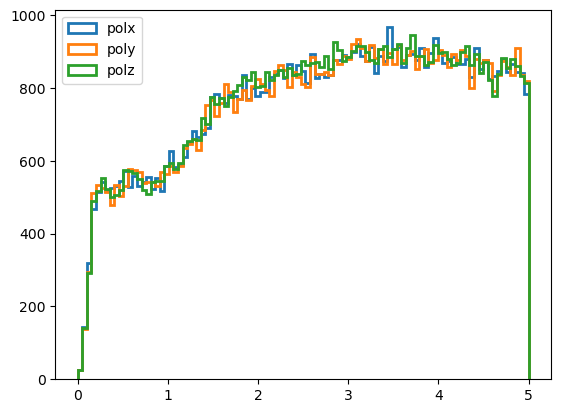

In [28]:
fig, ax = plt.subplots()
for pol, label in ((polx, "polx"), (poly, "poly"), (polz, "polz")):
    ax.hist(tau_visible_e(pol), bins=np.linspace(0, e, 100), histtype="step", label=label, lw=2)
ax.legend()

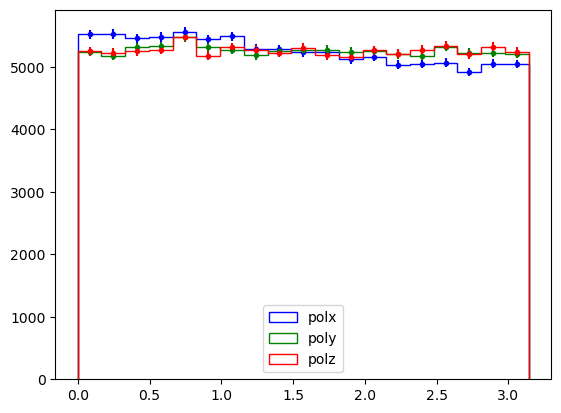

In [42]:
fig, ax = plt.subplots()
bins = np.linspace(0, np.pi, 20)
for pol, label, c in ((polx, "polx", "b"), (poly, "poly", "g"), (polz, "polz", "r")):
    values, *_ = ax.hist(tau_visible_cosphi(pol), bins=bins, histtype="step", label=label, color=c)
    ax.errorbar((bins[:-1] + bins[1:])/2, values, yerr=np.sqrt(values), fmt=".", color=c)
ax.legend()

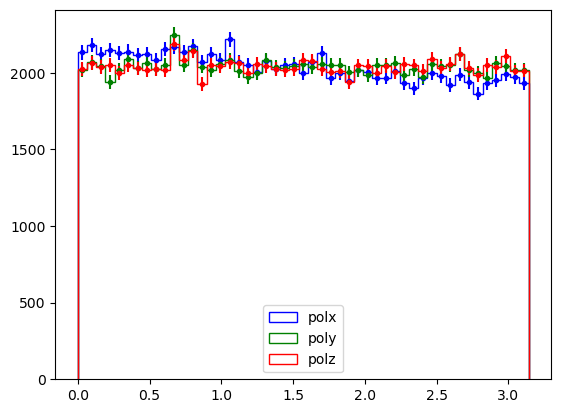

In [44]:
fig, ax = plt.subplots()
bins = np.linspace(0, np.pi, 50)
for pol, label, c in ((polx, "polx", "b"), (poly, "poly", "g"), (polz, "polz", "r")):
    values, *_ = ax.hist(tau_visible_cosphi_rest(pol), bins=bins, histtype="step", label=label, color=c)
    ax.errorbar((bins[:-1] + bins[1:])/2, values, yerr=np.sqrt(values), fmt=".", color=c)
ax.legend()

From this we can conclude that the x and y components do have an effect, albeit very small.